# Psych 198: Reproducibility DeCal (Spring 2021)

## Demo/Lab 2: Cross Validation

In this demo/lab, we will go through the a typical process for cross validating a linear model. Code adopted from Psych 102 and Data 100.

Author: Yuyang Zhong (2020). This work is licensed under a [Creative Commons BY-NC-SA 4.0 International
License][cc-by]. 

![CC BY-NC-SA 4.0][cc-by-shield]

[cc-by]: http://creativecommons.org/licenses/by/4.0/
[cc-by-shield]: https://img.shields.io/badge/license-CC--BY--NC--SA%204.0-blue

#### Note on using Jupyter Notebooks 
Enter code into a code cell, then press SHIFT+Enter to run that cell. The output of the code should be shown right underneath the cell you just run.

In [1]:
install.packages('psychTools')
install.packages('caTools')

library(car)
library(psychTools)
library(caTools)


The downloaded binary packages are in
	/var/folders/yg/07hqfnvn78z7x7hkd8_r1cl40000gn/T//RtmpHBkzlf/downloaded_packages

The downloaded binary packages are in
	/var/folders/yg/07hqfnvn78z7x7hkd8_r1cl40000gn/T//RtmpHBkzlf/downloaded_packages


Loading required package: carData



### The Dataset

We will be using the The Motivational State Questionnaire (MSQ). If you are interested in looking more into this dataset, run the code `?msq`.

Let's take a look at this dataset.

In [2]:
head(msq)

,active,afraid,alert,angry,anxious,aroused,ashamed,astonished,at.ease,at.rest,⋯,Sociability,Impulsivity,MSQ_Round,ID,condition,MSQ_Time,TOD,TOD24,scale,exper
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,1,1,1,0,1,1,0,0,1,1,⋯,3,4,15,193,2,15.30,15.00,NA,r,Rim.1
2,1,0,1,0,0,0,0,0,1,1,⋯,11,6,15,130,2,15.30,15.00,NA,r,Rim.2
3,1,0,0,0,0,0,0,0,2,2,⋯,8,5,15,2135,2,15.30,15.00,NA,r,Rim.2
4,1,0,1,0,1,1,1,0,1,2,⋯,12,7,NA,18,2,NA,NA,NA,r,COPE
5,2,0,1,0,NA,2,0,3,3,1,⋯,5,7,6,2,5,5.75,5.83,5.5,msq,rob-1
6,2,0,1,0,NA,1,0,0,1,1,⋯,10,7,6,3,5,5.75,5.83,5.5,msq,rob-1


#### Removing duplicates

In [3]:
sel <- complete.cases(msq[,'idle']) & complete.cases(msq[,'inspired']) & complete.cases(msq[, 'intense']) &
       complete.cases(msq[,'interested']) & complete.cases(msq[,'irritable']) & 
       complete.cases(msq[,'satisfied']) & complete.cases(msq[,'scared']) & complete.cases(msq[,'sleepy']) &
       complete.cases(msq[,'strong']) & complete.cases(msq[,'sociable']) & complete.cases(msq[,'happy'])
new_msq <- msq[sel, ]

#### Linear Model 1

Using multiple linear regression, fit a general linear model to predict `happy` using all affects that start with i : `idle` + `inspired` + `intense` + `interested` + `irritable`

In [4]:
i_mod <- lm(happy ~ idle + inspired + intense + interested + irritable, data=new_msq)
summary(i_mod)


Call:
lm(formula = happy ~ idle + inspired + intense + interested + 
    irritable, data = new_msq)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.02371 -0.52022 -0.09635  0.50216  2.86343 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.83507    0.03762  22.197  < 2e-16 ***
idle        -0.02293    0.01834  -1.250  0.21127    
inspired     0.34001    0.02434  13.972  < 2e-16 ***
intense      0.06641    0.02139   3.105  0.00193 ** 
interested   0.30715    0.02224  13.810  < 2e-16 ***
irritable   -0.31485    0.02201 -14.304  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7356 on 2004 degrees of freedom
Multiple R-squared:  0.3963,	Adjusted R-squared:  0.3948 
F-statistic: 263.1 on 5 and 2004 DF,  p-value: < 2.2e-16


#### Linear Model 2

In this model, we will combine all these predictors and use: `idle`, `inspired`, `intense`, `interested`, `irritable`, `satisfied`, `scared`, `sleepy`, `strong` and `sociable`.

In [5]:
is_mod <- lm(happy ~ idle + inspired + intense + interested + irritable +
             satisfied + scared + sleepy + strong + sociable, data = new_msq)
summary(is_mod)


Call:
lm(formula = happy ~ idle + inspired + intense + interested + 
    irritable + satisfied + scared + sleepy + strong + sociable, 
    data = new_msq)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.10728 -0.42594 -0.03228  0.36560  2.58635 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.21868    0.04396   4.974 7.10e-07 ***
idle        -0.01483    0.01624  -0.913   0.3613    
inspired     0.19077    0.02164   8.814  < 2e-16 ***
intense     -0.01444    0.02022  -0.714   0.4752    
interested   0.12139    0.02019   6.012 2.17e-09 ***
irritable   -0.13968    0.02032  -6.875 8.28e-12 ***
satisfied    0.31007    0.02009  15.437  < 2e-16 ***
scared      -0.05369    0.02987  -1.798   0.0724 .  
sleepy      -0.01667    0.01459  -1.142   0.2535    
strong       0.11255    0.01959   5.745 1.06e-08 ***
sociable     0.25358    0.01995  12.712  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard err

#### Difference in MSE

This is another measure we will take a look at: did the new model reduce error/noise?

In [6]:
mse1 <- mean(i_mod$residuals^2)
mse2 <- mean(is_mod$residuals^2)

mse1-mse2

[1] 0.1485508

### Cross Validation

We want to first partition the data into a training set and a test set. We will do a 75-25 split.

In [7]:
require(caTools)
set.seed(101)

sample <- sample.split(new_msq[,1], SplitRatio = .75)
train <- subset(new_msq, sample == TRUE)
test <- subset(new_msq, sample == FALSE)

In [8]:
nrow(train)

[1] 1507

In [9]:
nrow(test)

[1] 503

Now we will run our linear model through cross validation to see if the statistics we got is representative when the data is shuffled. We will do a 20-fold CV.

Again, **ONLY USE TRAINING DATA HERE**.

In [10]:
n.folds <- 20
folds <- cut(seq(1,nrow(train)),breaks=n.folds,labels=FALSE)

We will create some empty arrays to collect the models and the statistics.

In [11]:
MSE.imod <- array(data=0, dim = n.folds)    # Space for MSE
MSE.ismod <- array(data=0, dim = n.folds)

DE.i.is <- array(data=0, dim = n.folds)     # Space for differences in MSE
R2.i.is <- array(data=0, dim = n.folds)     # Space for R2

Now we will use a for-loop to help us run cross validation.

In [12]:
for(i in 1:n.folds){
    
    #Segement your data by fold using the which() function 
    validateIdx <- which(folds==i,arr.ind=TRUE)
    validateData <- train[validateIdx, ]
    trainData <- train[-validateIdx, ]

    # Fit the threes models
    i_lmod <- lm(happy ~ idle + inspired + intense + interested + irritable, 
                 data=trainData)
    is_lmod <- lm(happy ~ idle + inspired + intense + interested + irritable + 
                  satisfied + scared + sleepy + strong + sociable,
                  data = trainData)
    
    # Get predictions with validation data
    i_preds <- predict(i_lmod, validateData)
    is_preds <- predict(is_lmod, validateData)
    
    # Calculate the mean square errors.
    y <- validateData$happy
    MSE.imod[i] <- mean((y - i_preds)^2)
    MSE.ismod[i] <- mean((y - is_preds)^2)

    # Differences in error: (note - this can also be calculated outside the loop)
    DE.i.is[i] <- MSE.imod[i] - MSE.ismod[i]
    
    # Calculate R2 for the nested models. (this can also be done outside the loop)
    R2.i.is[i] <- 1 - (MSE.ismod[i]/MSE.imod[i])
}

We can then look at the averaged results from our cross validation, and compare it with our ANOVA. 

In [13]:
paste0("The average MSE for the model 1 was ", round(mean(MSE.imod),3))
paste0("The average MSE for the model 2 was ", round(mean(MSE.ismod),3))
paste0("The average R-squared for comparison between model 1 and 2 was ",
       round(mean(R2.i.is),3))

[1] "The average MSE for the model 1 was 0.54"

[1] "The average MSE for the model 2 was 0.392"

[1] "The average R-squared for comparison between model 1 and 2 was 0.27"

We can plot and see what the average differences in MSE are, and where our original model stand.

[1] 0.01501504 0.28053338

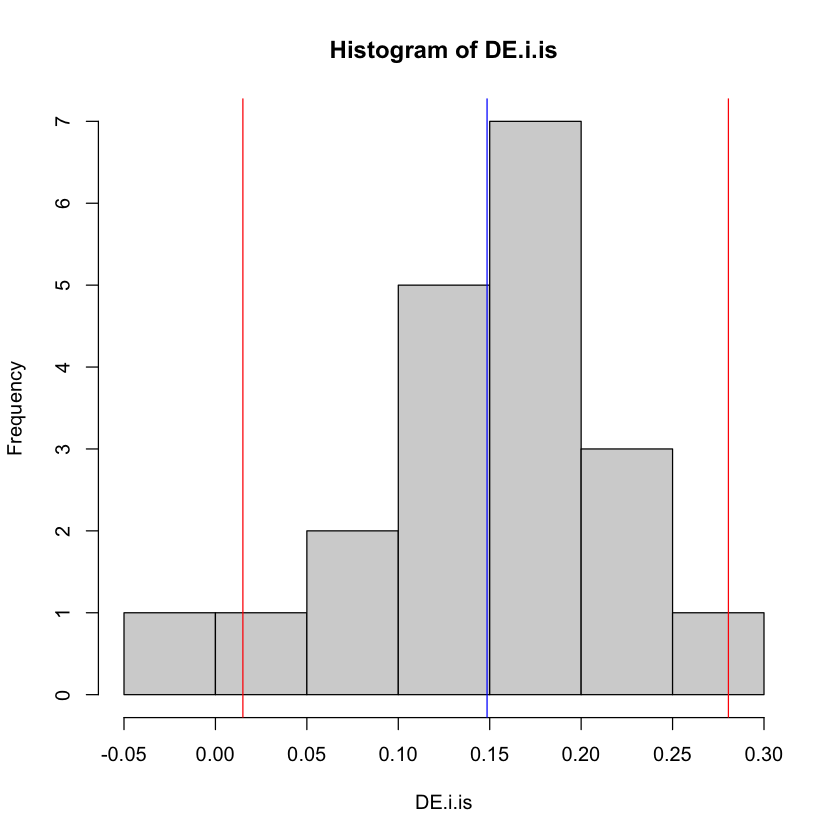

In [14]:
mean_i_is <- mean(DE.i.is)
se_i_is <- sd(DE.i.is)
c(mean_i_is-2*se_i_is, mean_i_is+2*se_i_is)
hist(DE.i.is)
abline(v=c(mean_i_is-2*se_i_is, mean_i_is+2*se_i_is), col="red")

abline(v=c(mse1-mse2), col="blue")

#### Testing

Now let's run our 2 models to predict our test data, and see how we do.

In [15]:
i_preds_test <- predict(i_lmod, test)
is_preds_test <- predict(is_lmod, test)

In [16]:
y <- test$happy
mse1_test <- mean((y - i_preds_test)^2)
mse2_test <- mean((y - is_preds_test)^2)

mse1_test - mse2_test

[1] 0.1436379

This is actually pretty close to what we had with our training set original models, as well as our cross validation results. We can plot this onto our histogram as well.

[1] 0.01501504 0.28053338

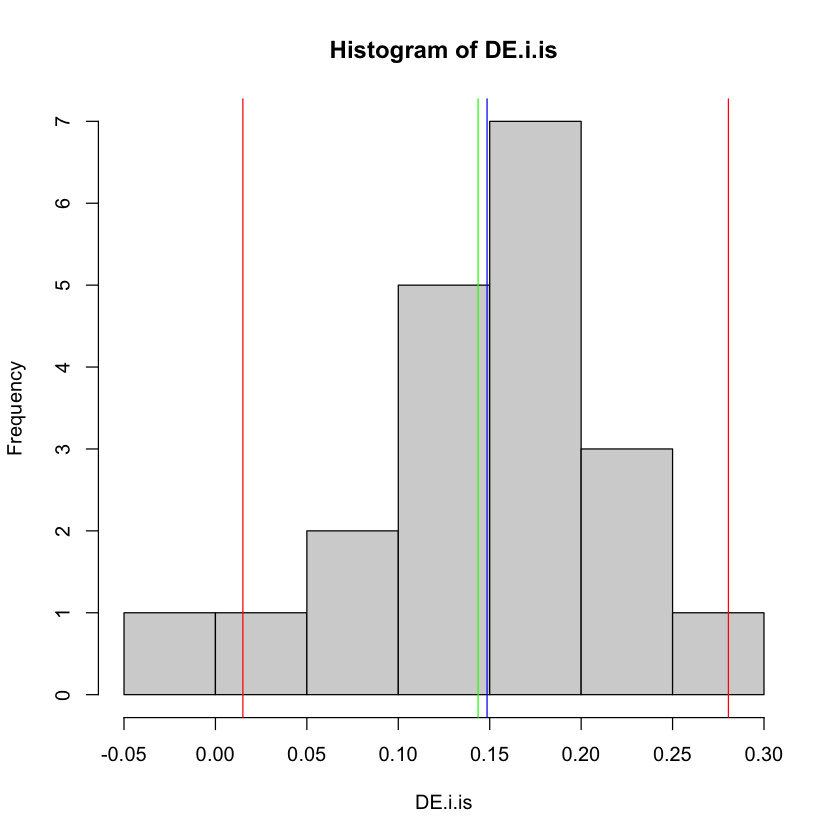

In [17]:
mean_i_is <- mean(DE.i.is)
se_i_is <- sd(DE.i.is)
c(mean_i_is-2*se_i_is, mean_i_is+2*se_i_is)
hist(DE.i.is)
abline(v=c(mean_i_is-2*se_i_is, mean_i_is+2*se_i_is), col="red")

abline(v=c(mse1-mse2), col="blue")
abline(v=c(mse1_test-mse2_test), col="green")

#### Exercise

There is another statistic in the model we have computed and stored, the $R^2$ of the nested model. Repeat this whole process and see if we can get similar results for $R^2$ as the differences in MSE we have calculated here. 